## Imports

In [111]:
import os
import sys

sys.path.append(os.path.abspath('..'))

import numpy as np
import matplotlib.pyplot as plt
import gpytorch
import torch
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

from src.models.Gpytorch_GP.batchedGPVariants import GPModel
from src.models.Gpytorch_GP.standardGP import standardGP
from src.utils.data_utils import generate_log_data, CustomScalerX
from src.data_gens.TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from src.utils.plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from src.utils.model_utils import *
from src.utils.data_utils import *

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DTYPE = torch.float64

%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Creating Data

Out noise


/home/codygrogan/PythonProjects/Uncertainty_Quantification/src/data_gens/TurbulenceClosureDataGenerator.py:89: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)/np.sqrt(-a**3/27))


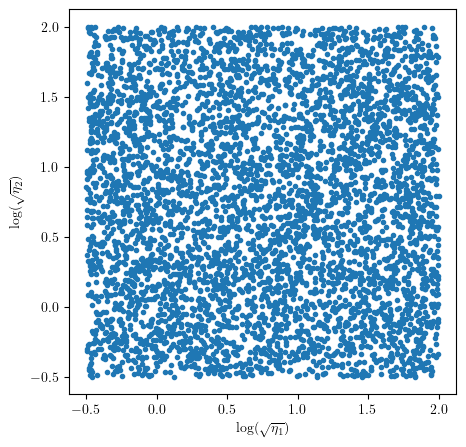

In [112]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 2.0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.1, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 5_000, shuffle=True, gen_type="All", noise_type="out_noise", noise=0.005)

etas_test, gs_test = generate_log_data(SSG_gen, log, 600, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(etas_train)

## Defining Data Sets and Scaling

In [113]:
from sklearn.preprocessing import StandardScaler

x_scaler = CustomScalerX().fit(etas_train)
y_scaler = StandardScaler().fit(gs_train)

x_train = torch.tensor(x_scaler.transform(etas_train), device=DEVICE, dtype=DTYPE)
y_train = torch.tensor(y_scaler.transform(gs_train), device=DEVICE, dtype=DTYPE)

x_test = torch.tensor(x_scaler.transform(etas_test), device=DEVICE, dtype=DTYPE)
y_test = torch.tensor(y_scaler.transform(gs_test), device=DEVICE, dtype=DTYPE)

## Hyper-Parameters

In [114]:
save_prefix = "Regular_Aleatoric_5k"
dir = "Aleatoric_High_5k"
save_dir = os.path.join("..", "Model_Checkpoints", "GP_Pytorch", dir)
out_dir = os.path.join("..", 'data', 'GP_Pytorch', dir, save_prefix)

NUM_EPOCHS = 3000
NUM_INDUCING = 400
NUM_DIM = x_train.shape[1]
BATCHES = 1

x_train = x_train.repeat(BATCHES,1,1)
y_train = y_train.squeeze().repeat(BATCHES,1)

## Training

In [115]:
gps = []
for i in range(y_train.shape[1]):
    INDUCING_PTS = torch.tensor(x_scaler.transform((10**np.random.uniform(*log, (NUM_INDUCING, NUM_DIM)))**2), dtype=DTYPE, device=DEVICE)
    sgp = standardGP(num_inducing=NUM_INDUCING, 
                    initial_inducing_pts=INDUCING_PTS, 
                    learn_inducing=False, 
                    num_dim=NUM_DIM, num_GPs=BATCHES, 
                    train_inp=x_train,
                    train_out=y_train[:,i],
                    device=DEVICE)
    trained_model = sgp.train(epochs=NUM_EPOCHS, learning_rate=0.02, train_noise=True)
    gps.append((sgp,trained_model))

Iter 1/3000 - Loss: 109.665   
Iter 2/3000 - Loss: 100.575   
Iter 3/3000 - Loss: 92.046   
Iter 4/3000 - Loss: 84.038   
Iter 5/3000 - Loss: 76.556   
Iter 6/3000 - Loss: 69.581   
Iter 7/3000 - Loss: 63.087   
Iter 8/3000 - Loss: 57.070   
Iter 9/3000 - Loss: 51.511   
Iter 10/3000 - Loss: 46.386   
Iter 11/3000 - Loss: 41.678   
Iter 12/3000 - Loss: 37.374   
Iter 13/3000 - Loss: 33.451   
Iter 14/3000 - Loss: 29.887   
Iter 15/3000 - Loss: 26.667   
Iter 16/3000 - Loss: 23.773   
Iter 17/3000 - Loss: 21.184   
Iter 18/3000 - Loss: 18.881   
Iter 19/3000 - Loss: 16.847   
Iter 20/3000 - Loss: 15.065   
Iter 21/3000 - Loss: 13.516   
Iter 22/3000 - Loss: 12.179   
Iter 23/3000 - Loss: 11.040   
Iter 24/3000 - Loss: 10.078   
Iter 25/3000 - Loss: 9.276   
Iter 26/3000 - Loss: 8.615   
Iter 27/3000 - Loss: 8.075   
Iter 28/3000 - Loss: 7.640   
Iter 29/3000 - Loss: 7.289   
Iter 30/3000 - Loss: 7.006   
Iter 31/3000 - Loss: 6.773   
Iter 32/3000 - Loss: 6.576   
Iter 33/3000 - Loss: 6.

## Saving Models

In [116]:
for i, (sgp, trained_model) in enumerate(gps):
    torch.save(trained_model.state_dict(), os.path.join(save_dir, f"{save_prefix}_{i}_Params.pt"))

# Loading Models

In [117]:
gps = []
for i in range(3):
    model_params = torch.load(os.path.join(save_dir, f"{save_prefix}_{i}_Params.pt"))
    sgp = standardGP(
        num_inducing=NUM_INDUCING, 
        initial_inducing_pts=INDUCING_PTS, 
        learn_inducing=True, 
        num_dim=NUM_DIM, 
        num_GPs=BATCHES, 
        train_inp=x_train,
        train_out=y_train[:,i],
        device=DEVICE
    )
    gp = sgp.train(epochs=0, learning_rate=0.01, model_params=model_params, train_noise=True)
    gps.append((sgp, gp))

## Plotting Samples

[[0.00514084 0.00510032 0.00495942]]
0.0006781019348253091


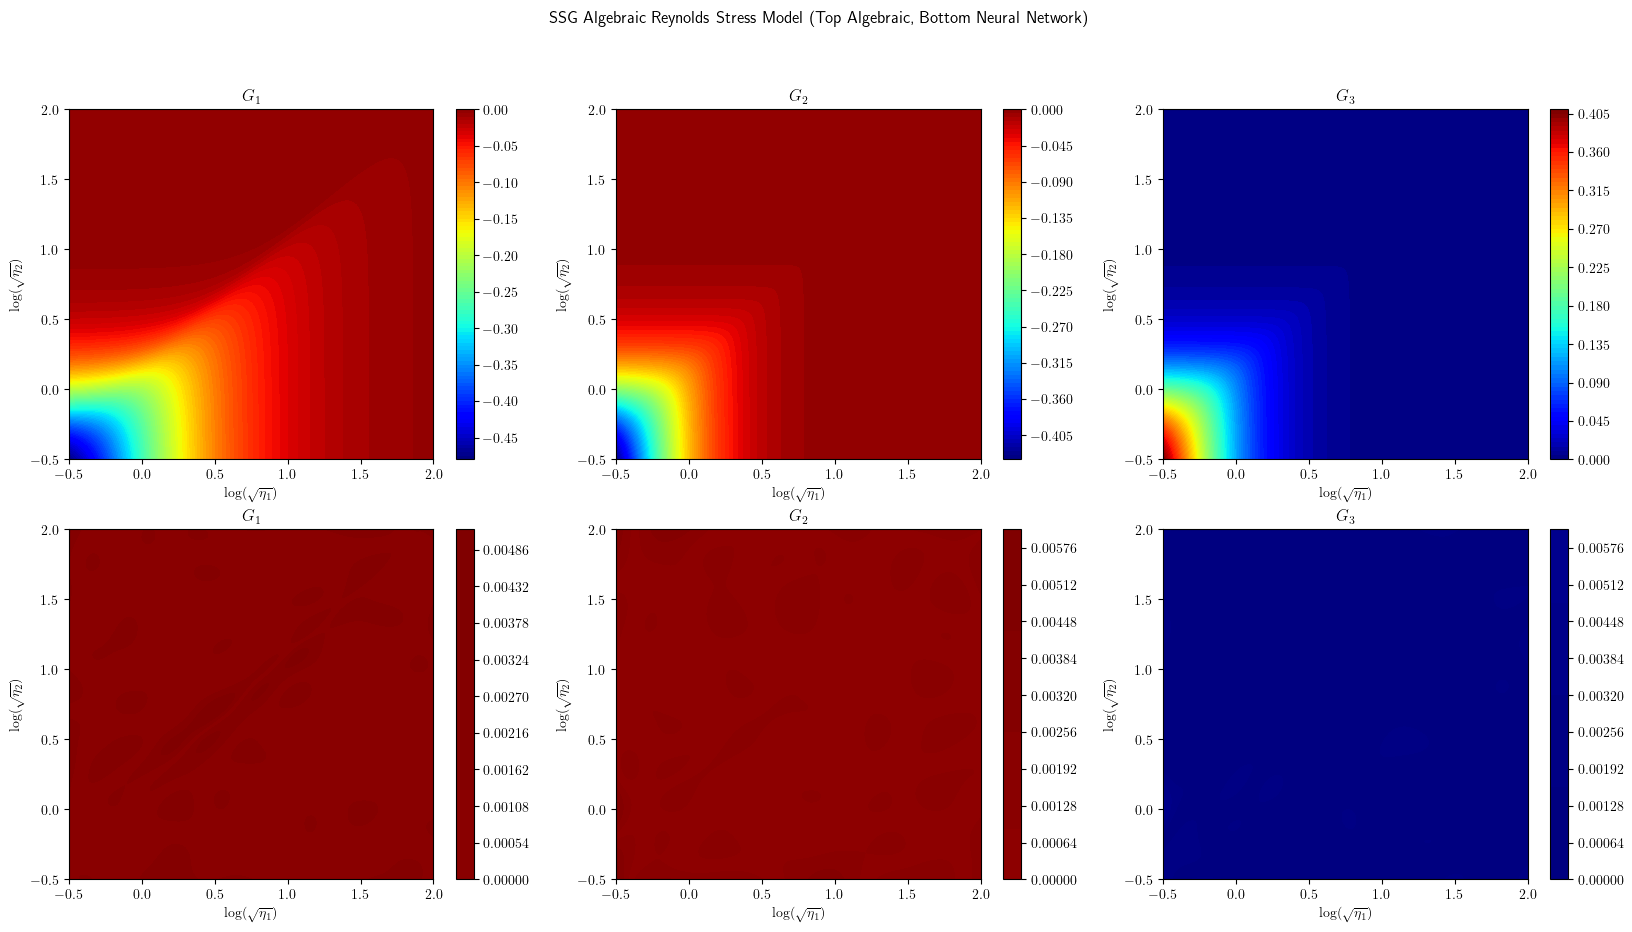

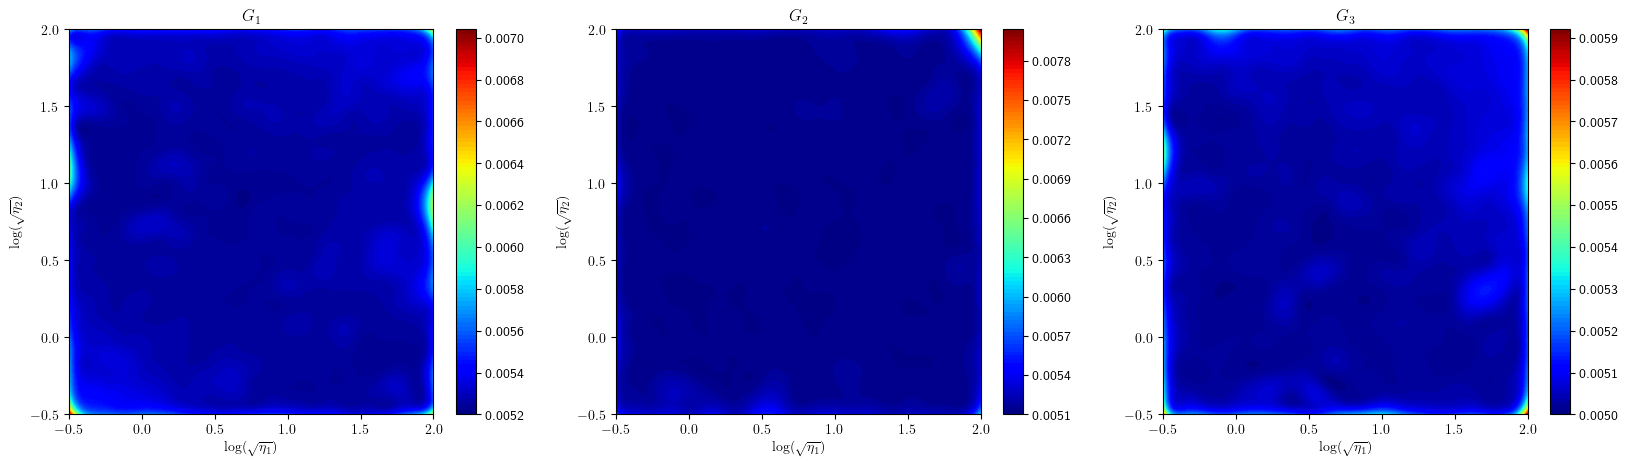

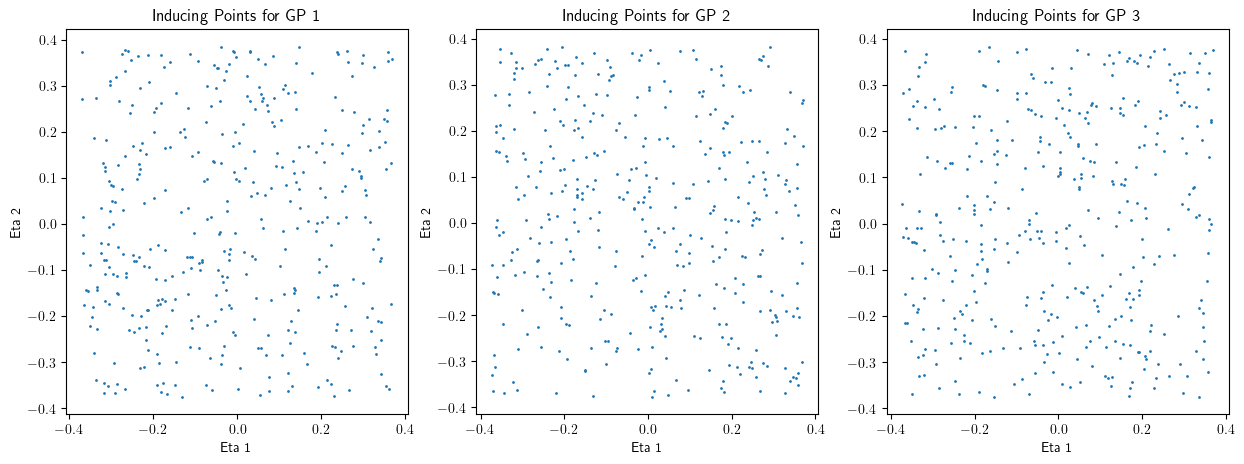

In [118]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

etas = x_scaler.transform(etas)
etas = torch.tensor(etas, device=DEVICE, dtype=torch.float32)

pred_mean = []
pred_std = []
obs_noise = []
inducing = []

for i, (sgp,model) in enumerate(gps):
    pred, std = sgp.predict(etas, model, batch_size=2000)
    pred = pred.cpu().detach().view(-1,1).numpy()
    std = std.cpu().detach().view(-1,1).numpy()
    pred_mean.append(pred)
    pred_std.append(np.sqrt(std))
    obs_noise.append(model.likelihood.noise.cpu().detach().numpy())
    inducing.append(x_scaler.inverse_transform(model.variational_strategy.inducing_points.cpu().detach().numpy()))

pred_mean = np.concatenate(pred_mean, axis=1)
pred_std = np.concatenate(pred_std, axis=1)
obs_noise = np.sqrt(np.concatenate(obs_noise, axis=0) * y_scaler.scale_.reshape(1, -1)**2)

np.savetxt(out_dir + "_Pred_Mean.csv", pred_mean, delimiter=',')
np.savetxt(out_dir + "_Pred_Std.csv", pred_std, delimiter=',')
np.savetxt(out_dir + "_Sigmas.csv", obs_noise, delimiter=',')

print(obs_noise)

pred_mean = y_scaler.inverse_transform(pred_mean)
pred_std = pred_std * y_scaler.scale_.reshape(1, -1)

print(np.mean(np.abs(target - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), np.abs(pred_mean-target).T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i in range(3):
    axs[i].scatter(np.log10(np.sqrt(inducing[i][:, 0])), np.log10(np.sqrt(inducing[i][:, 1])), s=1, label='Inducing Points')
    axs[i].set_title(f'Inducing Points for GP {i+1}')
    axs[i].set_xlabel('Eta 1')
    axs[i].set_ylabel('Eta 2')

plt.show()